<a href="https://colab.research.google.com/github/abhinabasaha/3D-Clustering-by-matplotlib/blob/master/FVQ_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn

In [2]:
!pip install scikit-fuzzy

In [0]:
import numpy as np
#from mnist import MNIST
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz
import itertools
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import fetch_openml
sns.set(style='white', context='poster')
#import umap
import umap.umap_ as umap
from scipy.stats import mode 
from collections import Counter 
from sklearn.metrics import accuracy_score

In [0]:
def normalize(vector):
    """
    Return the vector, normalized.
    If vector is 2d, treats it as stacked vectors, and normalizes each one.
    """
    if vector.ndim == 1:
        return vector / np.linalg.norm(vector)
    elif vector.ndim == 2:
        return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]
    else:
        raise_dimension_error(vector)

def magnitude(vector):
    """
    Compute the magnitude of `vector`. For stacked inputs, compute the magnitude
    of each one.
    Args:
        vector (np.arraylike): A `3x1` vector or a `kx3` stack of vectors.
    Returns:
        object: For `3x1` inputs, a `float` with the magnitude. For `kx1`
            inputs, a `kx1` array.
    """
    if vector.ndim == 1:
        return np.linalg.norm(vector)
    elif vector.ndim == 2:
        return np.linalg.norm(vector, axis=1)
    else:
        raise_dimension_error(vector)


# Alias because angle()'s parameter shadows the name.
_normalize = normalize


def angle(v1, v2, look=None, assume_normalized=False, units="deg"):
    """
    Compute the unsigned angle between two vectors. For stacked inputs, the
    angle is computed pairwise.
    When `look` is provided, the angle is computed in that viewing plane
    (`look` is the normal). Otherwise the angle is computed in 3-space.
    Args:
        v1 (np.arraylike): A `3x1` vector or a `kx3` stack of vectors.
        v2 (np.arraylike): A vector or stack of vectors with the same shape as
            `v1`.
        look (np.arraylike): A `3x1` vector specifying the normal of a viewing
            plane, or `None` to compute the angle in 3-space.
        assume_normalized (bool): When `True`, assume the input vectors
            are unit length. This improves performance, however when the inputs
            are not normalized, setting this will cause an incorrect results.
        units (str): `'deg'` to return degrees or `'rad'` to return radians.
    Return:
        object: For `3x1` inputs, a `float` with the angle. For `kx1` inputs,
            a `kx1` array.
    """
    if units not in ["deg", "rad"]:
        raise ValueError("Unrecognized units {}; expected deg or rad".format(units))

    if look is not None:
        # This is a simple approach. Since this is working in two dimensions,
        # a smarter approach could reduce the amount of computation needed.
        v1, v2 = [reject(v, from_v=look) for v in (v1, v2)]

    dot_products = np.einsum("ij,ij->i", v1.reshape(-1, 3), v2.reshape(-1, 3))

    if assume_normalized:
        cosines = dot_products
    else:
        cosines = dot_products / magnitude(v1) / magnitude(v2)

    # Clip, because the dot product can slip past 1 or -1 due to rounding and
    # we can't compute arccos(-1.00001).
    angles = np.arccos(np.clip(cosines, -1.0, 1.0))
    if units == "deg":
        angles = np.degrees(angles)

    return angles[0] if v1.ndim == 1 and v2.ndim == 1 else angles


def uniform_midtread_quantizer(x, Q):
    '''
    x: input array
    Q: quantization step
    '''
    # limiter
    x = np.copy(x)
    idx = np.where(np.abs(x) >= 1)
    x[idx] = np.ones(x[idx].shape)
    # linear uniform quantization
    xQ = np.round(Q * np.floor(x/Q + 1/2),6)

    return xQ

def fuzzified(s,m,l):
    V_fuzzified=[]

    for i in range(len(s)):
        V_fuzzified.append([ ])
    
    for i in range(len(s)):
        f=[s[i],m[i],l[i]]
        #f1=np.asarray(f1)
        V_fuzzified[i].append(f)
    return np.squeeze(V_fuzzified,axis=1)



def mostCommon(lst): 
          
    return [Counter(col).most_common(1)[0][0] for col in zip(*lst)] 



def mostCommon1(lst): 
	
	val, count = mode(lst, axis = 0) 
	return val.ravel().tolist() 
		
    
def euclidistance(arr1,arr2):
        return np.linalg.norm(arr1-arr2)
    

In [5]:
%%time
mndata = fetch_openml('mnist_784')
#mndata = MNIST('fashion-mnist/data/fashion')
#train, train_labels = mndata.load_training()
#test, test_labels = mndata.load_testing()
train, test, train_labels, test_labels = train_test_split(mndata.data,
                            mndata.target,
                            stratify=mndata.target,
                            random_state=42)

data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'Seven',
    'eight',
    'nine']


CPU times: user 16 s, sys: 899 ms, total: 16.9 s
Wall time: 17 s


# Showing the first nine digits

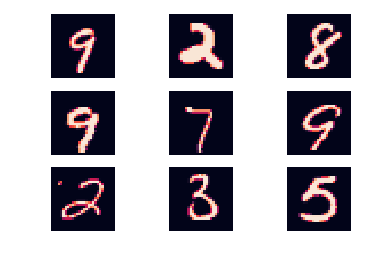

In [6]:
d=pd.DataFrame(data)


f=[]
for i in range(9):
  f.append([])

for i in range(9):
    f[i]=data[i,:].reshape(28,28)
    #plt.figure(figsize=(10,10))
    plt.subplot(3, 3, i+1)
    plt.imshow(f[i])
    plt.axis('off')
  




# Using umap for dimension reduction. 

In [0]:
train_data = np.array(train)
test_data = np.array(test)


In [8]:
%%time
mapper = umap.UMAP(n_components=3).fit(train_data, y=np.array(train_labels))


CPU times: user 2min 30s, sys: 5.65 s, total: 2min 36s
Wall time: 2min 11s


In [9]:
mapper.embedding_.shape

(52500, 3)

Text(0.5, 0.92, 'Fashion MNIST Embedded via UMAP using Labels')

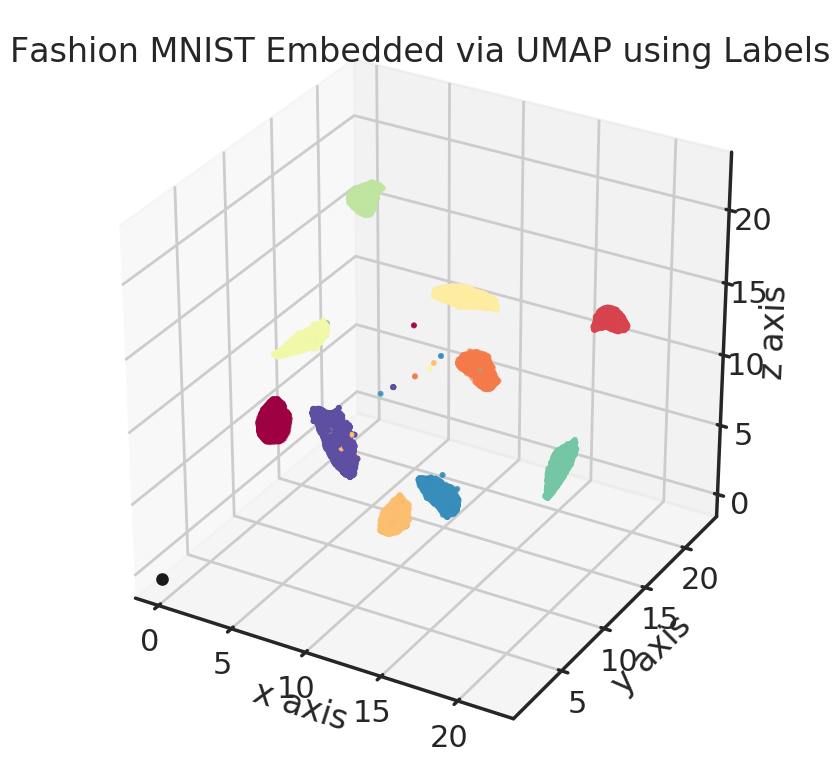

In [10]:
mapper.embedding_[:,0]=mapper.embedding_[:,0]-min(mapper.embedding_[:, 0])
mapper.embedding_[:,1]=mapper.embedding_[:,1]-min(mapper.embedding_[:, 1])
mapper.embedding_[:,2]=mapper.embedding_[:,2]-min(mapper.embedding_[:, 2])

%matplotlib inline

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.dpi']=100

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],mapper.embedding_[:, 2], c=train_labels.astype(int), cmap='Spectral', s=5)
ax.scatter(0, 0, 0, c='k', s=50)
plt.gca().set_aspect('equal', 'datalim')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Fashion MNIST Embedded via UMAP using Labels', fontsize=24)

In [0]:
import pandas as pd 

dataset = pd.DataFrame({'Column1': train_labels, 'Column2': mapper.embedding_[:, 0], 'Column3': mapper.embedding_[:, 1], 'Column4': mapper.embedding_[:, 2]})


In [0]:
for i in range(len(classes)):
    locals()["class"+str(i)+"_index"] = dataset.loc[dataset['Column1']==str(i)].index.values
    locals()["class"+str(i)] = mapper.embedding_[locals()["class"+str(i)+"_index"],:]


In [13]:
dataset.head(5)

,Column1,Column2,Column3,Column4
0,9,12.578474,0.550196,12.406523
1,2,11.152792,16.835497,9.415204
2,8,14.511477,7.484563,6.438943
3,9,11.743761,0.762549,12.659290
4,7,21.726971,8.167208,10.109634


In [14]:
class0_index.shape

(5177,)

In [15]:
class0[0,:]

array([ 0.78289413, 10.806461  ,  4.1008368 ], dtype=float32)

In [0]:
max1=np.linalg.norm(np.asarray([max(mapper.embedding_[:,0]),max(mapper.embedding_[:,1]),max(mapper.embedding_[:,2])]))
min1=np.linalg.norm(np.asarray([min(mapper.embedding_[:,0]),min(mapper.embedding_[:,1]),min(mapper.embedding_[:,2])]))
mid1=max1/2



In [0]:
for i in range(len(classes)):
    locals()["digit"+str(i)]=[]
    for j in range(len(locals()["class"+str(i)])):
        m=np.linalg.norm(locals()["class"+str(i)][j])
        locals()["digit"+str(i)].append(m)


In [18]:
np.asarray(digit1).shape


(5908,)

In [0]:
sigma=12
for i in range(len(classes)):
    locals()["V"+str(i)] = np.asarray(locals()["digit"+str(i)])

    locals()["s"+str(i)] = fuzz.membership.gaussmf(locals()["V"+str(i)], 0, sigma)
    locals()["m"+str(i)] = fuzz.membership.gaussmf(locals()["V"+str(i)], mid1, sigma)
    locals()["l"+str(i)] = fuzz.membership.gaussmf(locals()["V"+str(i)], max1, sigma)

#V1=np.asarray(digit1)

#s1 = fuzz.membership.gaussmf(V1, 0, sigma)
#m1 = fuzz.membership.gaussmf(V1, mid1, sigma)
#l1 = fuzz.membership.gaussmf(V1, max1, sigma)




In [0]:
for i in range(len(classes)):
    locals()["V"+str(i)+"_fuzzified"]=fuzzified(locals()["s"+str(i)],locals()["m"+str(i)],locals()["l"+str(i)])


In [21]:
V1_fuzzified.shape

(5908, 3)

In [22]:
%%time

d=[]
s=[]

for j in range(5,100,1):
    step_size = 1/j
    for i in range(len(classes)):
        locals()["V"+str(i)+"_fuzz"] = uniform_midtread_quantizer(locals()["V"+str(i)+"_fuzzified"], step_size)   #Quantization of fuzzified vectors
    
    for i in range(len(classes)):
        locals()["V"+str(i)+"_fuzzlist"] = locals()["V"+str(i)+"_fuzz"].tolist()  #Converting Fuzzified Vectors to lists
      
    for i in range(len(classes)):  
        locals()["max_v"+str(i)] = mostCommon(locals()["V"+str(i)+"_fuzzlist"]) #Computing the centroids of each quantized vectors by majority count
    
    
    numbers = [max_v0, max_v1, max_v2, max_v3, max_v4, max_v5, max_v6, max_v7, max_v8, max_v9]
    xc = np.asarray(list(itertools.combinations(numbers, 2)))                                    # Combinations of all the Class Centroids
    #xc
    
    
    distance=[]                                                                   # Getting the Optimized step size of the quantizer
                                                                                  # Computing Distance between each cluster
    for k in range(len(xc)):                                                      # Here total 10 clusters, so 45 combinations (10C2) of class centroids
        dis = euclidistance(xc[k,0,:],xc[k,1,:])                                  # Computing 45 distances and appending to a list
        if dis != 0:                                                              # Taking the sum of all 45 distances 
            distance.append(dis)                                                  # Clearing that list if any of the distance is zero
        else:                                                                     # Taking the index of that list where the sum is maximum
            distance.clear()                                                      # This index (+5) is the optimized step size of the quantizer
            break
    
    ss=sum(distance)
    d.append(distance)
    s.append(ss)
    print(ss)



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
17.248041029143387
0
17.289350684121437
0
17.22351178288203
16.943600927188324
0
16.892785498767353
0
16.82586547049154
0
0
0
0
0
0
0
0
0
0
16.716089168535717
0
16.5814174549663
17.04268296766056
0
0
16.84251650259123
0
16.77691256677055
0
0
0
16.835798337713804
0
16.70853669427159
0
0
0
16.8431850427787
0
16.55087636298827
0
0
0
0
0
16.647811407400564
0
16.759767312326915
16.630806717281935
0
0
16.626290320636095
0
16.64092196680156
0
0
16.83031917928471
16.635728141777218
16.6837164214323
16.641287163088705
16.5409560368527
16.687558855883754
16.545016194654703
16.70749313159407
16.58094945698194
16.69466428094325
16.63839842911255
16.778905583881727
16.551105406912075
16.5900909818156
16.651997237592887
16.748409597841164
CPU times: user 11.2 s, sys: 43.5 ms, total: 11.2 s
Wall time: 11.2 s


In [0]:
sum_dist=pd.DataFrame(s)    # Converting the list of summations of distances to dataframe

Getting the indices where the summation is is not zero

In [24]:
sum_index = sum_dist.loc[sum_dist[0]!=0].index.values   # Getting the indices
sum_index

array([22, 24, 26, 27, 29, 31, 42, 44, 45, 48, 50, 54, 56, 60, 62, 68, 70,
       71, 74, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93, 94])

Getting the index where the summation is maximum

In [25]:
max_value = max(s)
max_index = s.index(max_value)
max_index

24

In [26]:
test_labels.shape

(17500,)

Quantizing with the optimized step size

In [27]:
%%time
#pred_label=[]
#for j in sum_index:
step_size = 1/(max_index+5)
for i in range(len(classes)):
    locals()["V"+str(i)+"_fuzz"] = uniform_midtread_quantizer(locals()["V"+str(i)+"_fuzzified"], step_size)

for i in range(len(classes)):
    locals()["V"+str(i)+"_fuzzlist"] = locals()["V"+str(i)+"_fuzz"].tolist()

for i in range(len(classes)):  
    locals()["max_v"+str(i)] = mostCommon(locals()["V"+str(i)+"_fuzzlist"])

CPU times: user 146 ms, sys: 1.86 ms, total: 148 ms
Wall time: 154 ms


Plotting with optimized step size of the quantizer

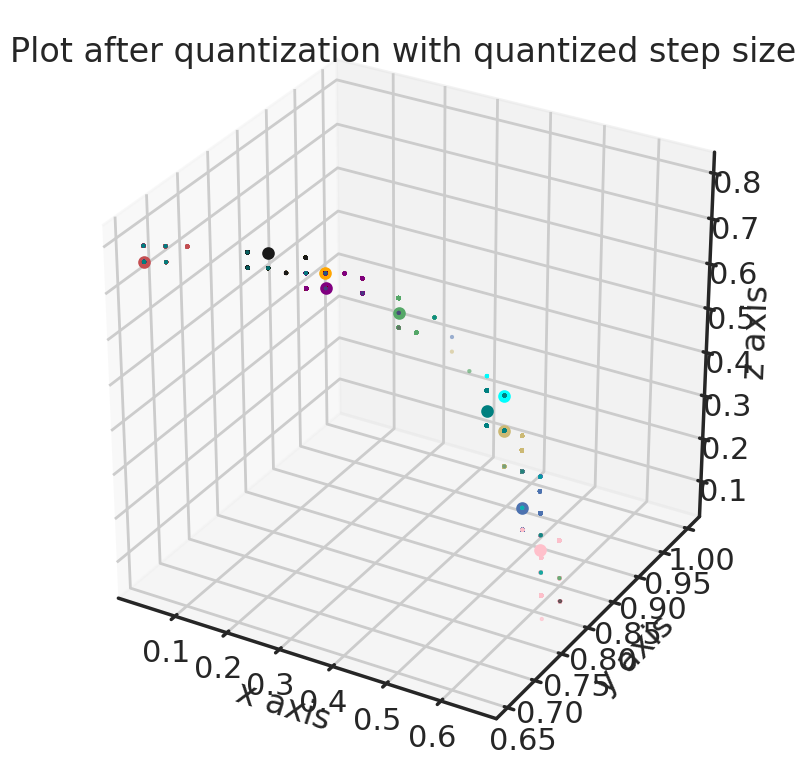

In [28]:

%matplotlib inline

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.dpi']=100

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

ax.scatter(V0_fuzz[:,0], V0_fuzz[:,1], V0_fuzz[:,2], c='pink', s=1, label='vector 0')
ax.scatter(V1_fuzz[:,0], V1_fuzz[:,1], V1_fuzz[:,2], c='r', s=1, label='vector 1')
ax.scatter(V2_fuzz[:,0], V2_fuzz[:,1], V2_fuzz[:,2], c='g', s=1, label='vector 2')
ax.scatter(V3_fuzz[:,0], V3_fuzz[:,1], V3_fuzz[:,2], c='b', s=1, label='vector 3')
ax.scatter(V4_fuzz[:,0], V4_fuzz[:,1], V4_fuzz[:,2], c='k', s=1, label='vector 4')
ax.scatter(V5_fuzz[:,0], V5_fuzz[:,1], V5_fuzz[:,2], c='y', s=1, label='vector 5')
ax.scatter(V6_fuzz[:,0], V6_fuzz[:,1], V6_fuzz[:,2], c='orange', s=1, label='vector 6')
ax.scatter(V7_fuzz[:,0], V7_fuzz[:,1], V7_fuzz[:,2], c='purple', s=1, label='vector 7')
ax.scatter(V8_fuzz[:,0], V8_fuzz[:,1], V8_fuzz[:,2], c='teal', s=1, label='vector 8')
ax.scatter(V9_fuzz[:,0], V9_fuzz[:,1], V9_fuzz[:,2], c='cyan', s=1, label='vector 9')

ax.scatter(max_v0[0], max_v0[1], max_v0[2], c='pink', s=50, label='vector 3' )
ax.scatter(max_v1[0], max_v1[1], max_v1[2], c='r', s=50, label='vector 3')
ax.scatter(max_v2[0], max_v2[1], max_v2[2], c='g', s=50, label='vector 3')
ax.scatter(max_v3[0], max_v3[1], max_v3[2], c='b', s=50, label='vector 3')
ax.scatter(max_v4[0], max_v4[1], max_v4[2], c='k', s=50, label='vector 3')
ax.scatter(max_v5[0], max_v5[1], max_v5[2], c='y', s=50, label='vector 3')
ax.scatter(max_v6[0], max_v6[1], max_v6[2], c='orange', s=50, label='vector 3')
ax.scatter(max_v7[0], max_v7[1], max_v7[2], c='purple', s=50, label='vector 3')
ax.scatter(max_v8[0], max_v8[1], max_v8[2], c='teal', s=50, label='vector 3')
ax.scatter(max_v9[0], max_v9[1], max_v9[2], c='cyan', s=50, label='vector 3')


#ax.legend()
plt.title('Plot after quantization with quantized step size')
plt.show()

Gettin the accuracy with each step size

In [0]:
prediction_label=[]

for j in sum_index:
    prediction_label.append([])

In [30]:
%%time
pred_label=[]

for j in sum_index:
    step_size = 1/(j+5)
    for i in range(len(classes)):
        locals()["V"+str(i)+"_fuzz"] = uniform_midtread_quantizer(locals()["V"+str(i)+"_fuzzified"], step_size)

    for i in range(len(classes)):
        locals()["V"+str(i)+"_fuzzlist"] = locals()["V"+str(i)+"_fuzz"].tolist()

    for i in range(len(classes)):  
        locals()["max_v"+str(i)] = mostCommon(locals()["V"+str(i)+"_fuzzlist"])

    '''
    import random
    indx = random.randint(0,len(test_embedding))

    test_data_final = test_embedding[indx:indx+1]
    print(indx,test_data_final)
    test_embedding[332, 2]
    '''


    for i in range(len(mapper.embedding_)):
        mag_test=np.linalg.norm(mapper.embedding_[i])


        s_new = fuzz.membership.gaussmf(mag_test, 0, sigma)
        m_new = fuzz.membership.gaussmf(mag_test, mid1, sigma)
        l_new = fuzz.membership.gaussmf(mag_test, max1, sigma)

        V_new_fuzzified=[s_new,m_new,l_new]


        V_new_fuzz = uniform_midtread_quantizer(V_new_fuzzified, step_size)


        #V_new_fuzz_mag=np.linalg.norm(V_new_fuzz)
        #V_new_fuzz_xdirect = (V_new_fuzz[0]/V_new_fuzz_mag)
        #V_new_fuzz_ydirect = (V_new_fuzz[1]/V_new_fuzz_mag)
        #V_new_fuzz_zdirect = (V_new_fuzz[2]/V_new_fuzz_mag)


        #V_new_fuzz_mag

        for i in range(len(classes)):
            locals()["angle"+str(i)] = angle(V_new_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")


        '''
        angle1 = angle(V_new_fuzz, np.asarray(max_v1),look=None, units="deg")
        angle2 = angle(V_new_fuzz, np.asarray(max_v2),look=None, units="deg")
        angle3 = angle(V_new_fuzz, np.asarray(max_v3),look=None, units="deg")
        angle4 = angle(V_new_fuzz, np.asarray(max_v4),look=None, units="deg")
        angle5 = angle(V_new_fuzz, np.asarray(max_v5),look=None, units="deg")
        angle6 = angle(V_new_fuzz, np.asarray(max_v6),look=None, units="deg")
        angle7 = angle(V_new_fuzz, np.asarray(max_v7),look=None, units="deg")
        angle8 = angle(V_new_fuzz, np.asarray(max_v8),look=None, units="deg")
        angle9 = angle(V_new_fuzz, np.asarray(max_v9),look=None, units="deg")
        angle10 = angle(V_new_fuzz, np.asarray(max_v10),look=None, units="deg")
        '''


        predict={"0":angle0, "1":angle1, "2":angle2, "3":angle3, "4":angle4, "5":angle5, "6":angle6, "7":angle7, "8":angle8, "9":angle9}


        for key, val in predict.items():
            if val == min(predict.values()):
                k=key
        pred_label.append(k)
    
    print(accuracy_score(train_labels, pred_label))
    prediction_label.append(pred_label) 
    pred_label.clear()
    #pred_label=np.asarray(pred_label)
   # 
    # print(accuracy_score(train_labels, pred_label))

0.7426285714285714
0.7332761904761905
0.7549904761904762
0.7254666666666667
0.7356761904761905
0.732
0.715352380952381
0.6915809523809524
0.7252952380952381
0.7092571428571428
0.6937714285714286
0.7099047619047619
0.7095238095238096
0.7104761904761905
0.7024380952380952
0.7064761904761905
0.7090285714285715
0.7161142857142857
0.6986095238095238
0.7034666666666667
0.705047619047619
0.6985333333333333
0.7091619047619048
0.7036571428571429
0.6987428571428571
0.7011428571428572
0.6996571428571429
0.7103238095238095
0.7064571428571429
0.7010285714285714
0.7045904761904762
0.7026666666666667
0.7029333333333333
0.7016380952380953
0.6982285714285714
0.7126285714285714
CPU times: user 7min 37s, sys: 505 ms, total: 7min 37s
Wall time: 7min 37s


In [38]:
prediction_label

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [31]:
    '''
    import random
    indx = random.randint(0,len(test_embedding))

    test_data_final = test_embedding[indx:indx+1]
    print(indx,test_data_final)
    test_embedding[332, 2]
    '''


    for i in range(len(mapper.embedding_)):
        mag_test=np.linalg.norm(mapper.embedding_[i])


        s_new = fuzz.membership.gaussmf(mag_test, 0, sigma)
        m_new = fuzz.membership.gaussmf(mag_test, mid1, sigma)
        l_new = fuzz.membership.gaussmf(mag_test, max1, sigma)

        V_new_fuzzified=[s_new,m_new,l_new]


        V_new_fuzz = uniform_midtread_quantizer(V_new_fuzzified, step_size)


        #V_new_fuzz_mag=np.linalg.norm(V_new_fuzz)
        #V_new_fuzz_xdirect = (V_new_fuzz[0]/V_new_fuzz_mag)
        #V_new_fuzz_ydirect = (V_new_fuzz[1]/V_new_fuzz_mag)
        #V_new_fuzz_zdirect = (V_new_fuzz[2]/V_new_fuzz_mag)


        #V_new_fuzz_mag

        for i in range(len(classes)):
            locals()["angle"+str(i)] = angle(V_new_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")


        '''
        angle1 = angle(V_new_fuzz, np.asarray(max_v1),look=None, units="deg")
        angle2 = angle(V_new_fuzz, np.asarray(max_v2),look=None, units="deg")
        angle3 = angle(V_new_fuzz, np.asarray(max_v3),look=None, units="deg")
        angle4 = angle(V_new_fuzz, np.asarray(max_v4),look=None, units="deg")
        angle5 = angle(V_new_fuzz, np.asarray(max_v5),look=None, units="deg")
        angle6 = angle(V_new_fuzz, np.asarray(max_v6),look=None, units="deg")
        angle7 = angle(V_new_fuzz, np.asarray(max_v7),look=None, units="deg")
        angle8 = angle(V_new_fuzz, np.asarray(max_v8),look=None, units="deg")
        angle9 = angle(V_new_fuzz, np.asarray(max_v9),look=None, units="deg")
        angle10 = angle(V_new_fuzz, np.asarray(max_v10),look=None, units="deg")
        '''


        predict={"0":angle0, "1":angle1, "2":angle2, "3":angle3, "4":angle4, "5":angle5, "6":angle6, "7":angle7, "8":angle8, "9":angle9}


        for key, val in predict.items():
            if val == min(predict.values()):
                k=key
        pred_label.append(k)
    
    print(accuracy_score(train_labels, pred_label))
    prediction_label.append(pred_label) 
    pred_label.clear()
    
    #pred_label=np.asarray(pred_label)
   # print(accuracy_score(train_labels, pred_label))

0.7126285714285714


In [32]:
%%time
'''
import random
indx = random.randint(0,len(test_embedding))

test_data_final = test_embedding[indx:indx+1]
print(indx,test_data_final)
test_embedding[332, 2]
'''
pred_label=[]

for i in range(len(mapper.embedding_)):
    mag_test=np.linalg.norm(mapper.embedding_[i])
   

    s_new = fuzz.membership.gaussmf(mag_test, 0, sigma)
    m_new = fuzz.membership.gaussmf(mag_test, mid1, sigma)
    l_new = fuzz.membership.gaussmf(mag_test, max1, sigma)

    V_new_fuzzified=[s_new,m_new,l_new]
   

    V_new_fuzz = uniform_midtread_quantizer(V_new_fuzzified, step_size)
    

    #V_new_fuzz_mag=np.linalg.norm(V_new_fuzz)
    #V_new_fuzz_xdirect = (V_new_fuzz[0]/V_new_fuzz_mag)
    #V_new_fuzz_ydirect = (V_new_fuzz[1]/V_new_fuzz_mag)
    #V_new_fuzz_zdirect = (V_new_fuzz[2]/V_new_fuzz_mag)


    #V_new_fuzz_mag

    for i in range(len(classes)):
        locals()["angle"+str(i)] = angle(V_new_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")

    
    '''
    angle1 = angle(V_new_fuzz, np.asarray(max_v1),look=None, units="deg")
    angle2 = angle(V_new_fuzz, np.asarray(max_v2),look=None, units="deg")
    angle3 = angle(V_new_fuzz, np.asarray(max_v3),look=None, units="deg")
    angle4 = angle(V_new_fuzz, np.asarray(max_v4),look=None, units="deg")
    angle5 = angle(V_new_fuzz, np.asarray(max_v5),look=None, units="deg")
    angle6 = angle(V_new_fuzz, np.asarray(max_v6),look=None, units="deg")
    angle7 = angle(V_new_fuzz, np.asarray(max_v7),look=None, units="deg")
    angle8 = angle(V_new_fuzz, np.asarray(max_v8),look=None, units="deg")
    angle9 = angle(V_new_fuzz, np.asarray(max_v9),look=None, units="deg")
    angle10 = angle(V_new_fuzz, np.asarray(max_v10),look=None, units="deg")
    '''


    predict={"0":angle0, "1":angle1, "2":angle2, "3":angle3, "4":angle4, "5":angle5, "6":angle6, "7":angle7, "8":angle8, "9":angle9}


    for key, val in predict.items():
        if val == min(predict.values()):
            k=key
    pred_label.append(k)

pred_label=np.asarray(pred_label)

CPU times: user 12.5 s, sys: 1.98 ms, total: 12.5 s
Wall time: 12.5 s


In [0]:
def unit_vector(Vec):
    mag=np.linalg.norm(Vec)
    v_xdirect = (Vec[0]/mag)
    v_ydirect = (Vec[1]/mag)
    v_zdirect = (Vec[2]/mag)
    return(v_xdirect,v_ydirect,v_zdirect)

unit_vector(max_v1)[0]

numbers = [max_v1, max_v2, max_v3, max_v4, max_v5, max_v6, max_v7, max_v8, max_v9, max_v10]

for i in numbers:

    ax.quiver(0, 0, 0, unit_vector(i)[0],unit_vector(i)[1],unit_vector(i)[2], length = 0.8, normalize = True, color='r')

In [34]:
%matplotlib notebook

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.dpi']=100

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('low membership-->>')
ax.set_ylabel('medium membership-->>')
ax.set_zlabel('high membership-->>')


ax.scatter(V1_fuzz[:,0], V1_fuzz[:,1], V1_fuzz[:,2], c='r', s=1, label='vector 1')
ax.scatter(V2_fuzz[:,0], V2_fuzz[:,1], V2_fuzz[:,2], c='g', s=1, label='vector 1')
ax.scatter(V3_fuzz[:,0], V3_fuzz[:,1], V3_fuzz[:,2], c='b', s=1, label='vector 1')
ax.scatter(V4_fuzz[:,0], V4_fuzz[:,1], V4_fuzz[:,2], c='k', s=1, label='vector 1')
ax.scatter(V5_fuzz[:,0], V5_fuzz[:,1], V5_fuzz[:,2], c='y', s=1, label='vector 1')
ax.scatter(V6_fuzz[:,0], V6_fuzz[:,1], V6_fuzz[:,2], c='orange', s=1, label='vector 1')
ax.scatter(V7_fuzz[:,0], V7_fuzz[:,1], V7_fuzz[:,2], c='purple', s=1, label='vector 1')
ax.scatter(V8_fuzz[:,0], V8_fuzz[:,1], V8_fuzz[:,2], c='teal', s=1, label='vector 1')
ax.scatter(V9_fuzz[:,0], V9_fuzz[:,1], V9_fuzz[:,2], c='cyan', s=1, label='vector 1')
ax.scatter(V10_fuzz[:,0], V10_fuzz[:,1], V10_fuzz[:,2], c='pink', s=1, label='vector 1')

ax.scatter(max_v1[0], max_v1[1], max_v1[2], c='r', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v2[0], max_v2[1], max_v2[2], c='g', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v3[0], max_v3[1], max_v3[2], c='b', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v4[0], max_v4[1], max_v4[2], c='k', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v5[0], max_v5[1], max_v5[2], c='y', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v6[0], max_v6[1], max_v6[2], c='orange', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v7[0], max_v7[1], max_v7[2], c='purple', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v8[0], max_v8[1], max_v8[2], c='teal', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v9[0], max_v9[1], max_v9[2], c='cyan', s=50, label='vector 3', edgecolors='none')
ax.scatter(max_v10[0], max_v10[1], max_v10[2], c='pink', s=50, label='vector 3', edgecolors='none')


numbers = [max_v1, max_v2, max_v3, max_v4, max_v5, max_v6, max_v7, max_v8, max_v9, max_v10]

for i in numbers:
    ax.quiver(0, 0, 0, unit_vector(i)[0],unit_vector(i)[1],unit_vector(i)[2], length = np.linalg.norm(i), normalize = True, color=classes)

#ax.quiver(0, 0, 0, unit_vector(max_v1)[0],unit_vector(max_v1)[1],unit_vector(max_v1)[2], length = 0.8, normalize = True, color='r')
#ax.quiver(0, 0, 0, max_v2_xdirect, max_v2_ydirect, max_v2_zdirect, length = 0.8,normalize = True, color='g')
#ax.quiver(0, 0, 0, max_v3_xdirect, max_v3_ydirect, max_v3_zdirect, length = 0.98, normalize = True, color='b')

plt.title('Plot with direction vector')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>

NameError: ignored

<IPython.core.display.Javascript object>

In [0]:
%%time
test_embedding = mapper.transform(test_data)


In [0]:
len(test_embedding)

In [0]:
t_e = pd.DataFrame(test_embedding)
t_e

In [0]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],mapper.embedding_[:, 2], c=train_labels.astype(int), cmap='Spectral', s=5)
ax.scatter(test_embedding[indx, 0], test_embedding[indx, 1],test_embedding[indx, 2], c='k', cmap='Spectral', s=100)
ax.scatter(0, 0, 0, c='k', s=50)
plt.gca().set_aspect('equal', 'datalim')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Fashion MNIST Embedded via UMAP using Labels', fontsize=24);

In [0]:
%%time
'''
import random
indx = random.randint(0,len(test_embedding))

test_data_final = test_embedding[indx:indx+1]
print(indx,test_data_final)
test_embedding[332, 2]
'''
pred_label=[]

for i in range(len(mapper.embedding_)):
    mag_test=np.linalg.norm(mapper.embedding_[i])
   

    s_new = fuzz.membership.gaussmf(mag_test, 0, sigma)
    m_new = fuzz.membership.gaussmf(mag_test, mid1, sigma)
    l_new = fuzz.membership.gaussmf(mag_test, max1, sigma)

    V_new_fuzzified=[s_new,m_new,l_new]
   

    V_new_fuzz = uniform_midtread_quantizer(V_new_fuzzified, step_size)
    

    #V_new_fuzz_mag=np.linalg.norm(V_new_fuzz)
    #V_new_fuzz_xdirect = (V_new_fuzz[0]/V_new_fuzz_mag)
    #V_new_fuzz_ydirect = (V_new_fuzz[1]/V_new_fuzz_mag)
    #V_new_fuzz_zdirect = (V_new_fuzz[2]/V_new_fuzz_mag)


    #V_new_fuzz_mag

    for i in range(len(classes)):
        locals()["angle"+str(i)] = angle(V_new_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")

    
    '''
    angle1 = angle(V_new_fuzz, np.asarray(max_v1),look=None, units="deg")
    angle2 = angle(V_new_fuzz, np.asarray(max_v2),look=None, units="deg")
    angle3 = angle(V_new_fuzz, np.asarray(max_v3),look=None, units="deg")
    angle4 = angle(V_new_fuzz, np.asarray(max_v4),look=None, units="deg")
    angle5 = angle(V_new_fuzz, np.asarray(max_v5),look=None, units="deg")
    angle6 = angle(V_new_fuzz, np.asarray(max_v6),look=None, units="deg")
    angle7 = angle(V_new_fuzz, np.asarray(max_v7),look=None, units="deg")
    angle8 = angle(V_new_fuzz, np.asarray(max_v8),look=None, units="deg")
    angle9 = angle(V_new_fuzz, np.asarray(max_v9),look=None, units="deg")
    angle10 = angle(V_new_fuzz, np.asarray(max_v10),look=None, units="deg")
    '''


    predict={"0":angle0, "1":angle1, "2":angle2, "3":angle3, "4":angle4, "5":angle5, "6":angle6, "7":angle7, "8":angle8, "9":angle9}


    for key, val in predict.items():
        if val == min(predict.values()):
            k=key
    pred_label.append(k)

pred_label=np.asarray(pred_label)

In [0]:
pred_label.shape

In [0]:
train_labels.shape

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(train_labels, pred_label)

In [0]:
%%time
'''
import random
indx = random.randint(0,len(test_embedding))

test_data_final = test_embedding[indx:indx+1]
print(indx,test_data_final)
test_embedding[332, 2]
'''
pred_label=[]

for i in range(len(test_embedding)):
    mag_test=np.linalg.norm(test_embedding[i])
   

    s_new = fuzz.membership.gaussmf(mag_test, 0, sigma)
    m_new = fuzz.membership.gaussmf(mag_test, mid1, sigma)
    l_new = fuzz.membership.gaussmf(mag_test, max1, sigma)

    V_new_fuzzified=[s_new,m_new,l_new]
   

    V_new_fuzz = uniform_midtread_quantizer(V_new_fuzzified, step_size)
    

    #V_new_fuzz_mag=np.linalg.norm(V_new_fuzz)
    #V_new_fuzz_xdirect = (V_new_fuzz[0]/V_new_fuzz_mag)
    #V_new_fuzz_ydirect = (V_new_fuzz[1]/V_new_fuzz_mag)
    #V_new_fuzz_zdirect = (V_new_fuzz[2]/V_new_fuzz_mag)


    #V_new_fuzz_mag

    for i in range(len(classes)):
        locals()["angle"+str(i)] = angle(V_new_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")

    
    '''
    angle1 = angle(V_new_fuzz, np.asarray(max_v1),look=None, units="deg")
    angle2 = angle(V_new_fuzz, np.asarray(max_v2),look=None, units="deg")
    angle3 = angle(V_new_fuzz, np.asarray(max_v3),look=None, units="deg")
    angle4 = angle(V_new_fuzz, np.asarray(max_v4),look=None, units="deg")
    angle5 = angle(V_new_fuzz, np.asarray(max_v5),look=None, units="deg")
    angle6 = angle(V_new_fuzz, np.asarray(max_v6),look=None, units="deg")
    angle7 = angle(V_new_fuzz, np.asarray(max_v7),look=None, units="deg")
    angle8 = angle(V_new_fuzz, np.asarray(max_v8),look=None, units="deg")
    angle9 = angle(V_new_fuzz, np.asarray(max_v9),look=None, units="deg")
    angle10 = angle(V_new_fuzz, np.asarray(max_v10),look=None, units="deg")
    '''


    predict={"0":angle0, "1":angle1, "2":angle2, "3":angle3, "4":angle4, "5":angle5, "6":angle6, "7":angle7, "8":angle8, "9":angle9}


    for key, val in predict.items():
        if val == min(predict.values()):
            k=key
    pred_label.append(k)

pred_label=np.asarray(pred_label)

In [0]:
accuracy_score(test_labels, pred_label)